In [595]:
import pandas as pd
import numpy as np

## Get data for training and testing ready

In [596]:
#Path on my system to training data
train_path = "./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/"

In [597]:
#Read all training data files
from os import walk

data_for_fall=[]

for (dirpath, dirnames, filenames) in walk(train_path):
    
    for file in filenames:
        print(dirpath+file)
        data = pd.read_csv(dirpath+file)
        data.columns = ['Time','Rel_Time','Acc_X','Acc_Y','Acc_Z','Mg_X','Mg_Y','Mg_Z','Ang_X','Ang_Y','Ang_Z','Fall_indicator']
        data_for_fall.append(data)

./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_04835861-01-2013-10-16-13-19-35.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_17744725-01-2009-02-24-16-26-44.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_20983985-01-2013-05-16-16-16-00.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_23112025-01-2013-05-21-06-21-54.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_36551836-01-2013-05-21-17-39-57.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_38243026-05-2009-04-29-08-53-16.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_42990421-03a-2011-03-23-16-50-02.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_47451392-01-2014-01-22-22-42-34.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_63414187-01-2013-05-30-22-48-27.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Train/F_67458491-01-2013-11-07-12

In [598]:
#Print one file data in training
data_for_fall[0]

,Time,Rel_Time,Acc_X,Acc_Y,Acc_Z,Mg_X,Mg_Y,Mg_Z,Ang_X,Ang_Y,Ang_Z,Fall_indicator
0,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
1,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
2,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
3,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
4,184020.0,735520.0,2.0243,-8.4086,-2.95860,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
23995,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0
23996,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0
23997,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0
23998,185220.0,735520.0,8.7200,-1.8686,0.31143,0,0,0,0,0,0,0


In [599]:
from scipy import stats
#Creates windows of size=20 and steps forward by 1
def create_dataset(X, Y, feature_size=20, step_size=1):
    window_X, window_Y = [], []
    for i in range(0, len(X) - feature_size, step_size):
        #Feature size=20 (size of window)
        window_data = X.iloc[i:(i + feature_size),:]
        #Get all the 20 labels
        labels = Y.iloc[i: i + feature_size]
        #Append for each 20 sized windows, each stepped forward by 1
        window_X.append(window_data)
        #Get the max value- If window contains the row that has fall data then window labelled as fall
        #The fall indicator can be any value >0 dependng on severity of fall
        window_Y.append(labels.max())
    return (window_X), np.array(window_Y).reshape(-1, 1)

In [600]:
def to_features(data):
    #Flattens the window data into one row
    #Will get 20 rows of 3 columns each = 60 data points in each row
    feature_columns = ['Acc_X','Acc_Y','Acc_Z']
    sensor_values = data[feature_columns].values 
    features = sensor_values.flatten()
    return features

In [630]:
from itertools import chain

#Get the training window data without overlap from other files
# train_X_window = np.empty((0, 20, 3)) 
# train_Y_window = np.array([])
train_X_window_fall = []
train_Y_window_fall = []

train_X_window_non_fall = []
train_Y_window_non_fall = []

#For each file in the 16 training files
for dataset in data_for_fall:
    #Get the fall event location in the file (only one file at a time)
    fall_event_loc = dataset[dataset['Fall_indicator']>0].index
    
    #Get 2 seconds of data around fall event
    for fall_loc in fall_event_loc:
        data_index_lists = []
        #2s of data - 1.5sec before fall, 0.5sec after fall
        data_index_lists.append(list(range(fall_loc-45,fall_loc+25)))
        #Get all the indices as a list    
        drop_arr = list(chain.from_iterable(data_index_lists))
        #Take only those indices that correspond to 2 seconds of data around fall event
        dataset_sample = dataset.iloc[drop_arr]
    

        #Create windowed data for the file
        train_each_X, train_each_Y = create_dataset(
            dataset_sample[['Acc_X', 'Acc_Y', 'Acc_Z']],
            dataset_sample[['Fall_indicator']],
            feature_size=20
        )
    
        #Adding only non-fall data from the files
        data_index_lists_non_fall=[]
        #1.2s of data - 10 seconds before fall, duration is 1.2 seconds
        data_index_lists_non_fall.append(list(range(fall_loc-600,fall_loc-540)))
        #Get all the indices as a list    
        drop_arr = list(chain.from_iterable(data_index_lists_non_fall))
        #Take only those indices that correspond to 2 seconds of data around fall event
        dataset_sample_non_fall = dataset.iloc[drop_arr]


        #Create windowed data for the file
        train_each_X_non_fall, train_each_Y_non_fall = create_dataset(
            dataset_sample_non_fall[['Acc_X', 'Acc_Y', 'Acc_Z']],
            dataset_sample_non_fall[['Fall_indicator']],
            feature_size=20
        )

    #     print("Fall data dim ",train_each_X.shape," and ",train_each_Y.shape)
    #     print("\n Non Fall data dim ",train_each_X_non_fall.shape," and ",train_each_Y_non_fall.shape)

        #Flatten the windowed data to get 60 features in a row
        train_each_X_flat = np.stack([to_features(d) for d in train_each_X])
        train_each_X_non_fall_flat = np.stack([to_features(d) for d in train_each_X_non_fall])

    
    #     print("Fall data dim ",len(train_each_X_flat)," and ",len(train_each_Y))
    #     print("\n Non Fall data dim ",len(train_each_X_non_fall_flat)," and ",len(train_each_Y_non_fall))

        #Append the data of each file
        #Append non-fall data only once in 3 times

        train_X_window_non_fall.append(train_each_X_non_fall_flat)
        train_X_window_fall.append(train_each_X_flat)

        train_Y_window_non_fall.append(train_each_Y_non_fall)
        train_Y_window_fall.append(train_each_Y)
    

In [631]:
len(train_Y_window_fall[1])

50

In [632]:
len(train_Y_window_non_fall[1])

40

In [633]:
train_X_window_fall[1].shape

(50, 60)

In [634]:
train_Y_window_fall[1].shape

(50, 1)

In [635]:
train_X_window_fall[1]

array([[ -2.9221 ,   1.1522 ,   8.1011 , ...,  -3.7665 ,  -0.37785,
          5.0287 ],
       [ -2.5426 ,   1.4321 ,   7.0365 , ...,  -4.1555 ,  -0.71371,
          4.5898 ],
       [ -2.5142 ,   1.8426 ,   5.1221 , ...,  -3.0834 ,  -0.55511,
          4.291  ],
       ...,
       [ 19.231  ,   4.5761 ,  18.98   , ...,  13.301  , -11.387  ,
          5.589  ],
       [ 19.231  ,   7.0858 ,  18.98   , ...,  15.816  ,   1.9825 ,
          5.2622 ],
       [ 19.231  ,  11.097  ,  -2.7221 , ...,  13.311  ,   4.3242 ,
          8.0077 ]])

In [636]:
len(train_X_window_fall)

17

In [637]:
for each_window in train_X_window_fall:
    print(len(each_window))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50


In [638]:
train_X_window_fall.insert(1,train_X_window_non_fall[0])
train_Y_window_fall.insert(1,train_Y_window_non_fall[0])



train_X_window_fall.insert(6,train_X_window_non_fall[5])
train_Y_window_fall.insert(6,train_Y_window_non_fall[5])


train_X_window_fall.insert(8,train_X_window_non_fall[7])
train_Y_window_fall.insert(8,train_Y_window_non_fall[7])


train_X_window_fall.insert(11,train_X_window_non_fall[10])
train_Y_window_fall.insert(11,train_Y_window_non_fall[10])



train_X_window_fall.insert(16,train_X_window_non_fall[15])
train_Y_window_fall.insert(16,train_Y_window_non_fall[15])


In [639]:
for each_window in train_X_window_fall:
    print(len(each_window))

50
40
50
50
50
50
40
50
40
50
50
40
50
50
50
50
40
50
50
50
50
50


In [640]:
len(train_X_window_fall)

22

In [641]:
len(train_Y_window_fall)

22

In [642]:
#Concatenate the windowed and flattened data of each file to form the training data
train_X = np.concatenate(train_X_window_fall, axis =0)
train_X

array([[-2.4914 , -1.7129 ,  9.3429 , ..., -4.2043 , -9.3429 , 11.056  ],
       [-3.5814 ,  0.31143, 10.589  , ..., -2.3357 ,  1.2457 ,  9.3429 ],
       [-1.7129 ,  1.2457 , 10.433  , ..., -1.4014 , -0.46714,  9.4986 ],
       ...,
       [29.859  ,  9.7819 , 51.589  , ..., 20.76   , 19.156  ,  2.4606 ],
       [56.585  ,  4.7431 , 57.15   , ..., 12.977  ,  6.0099 , -1.4597 ],
       [51.95   , 16.707  , 57.15   , ..., 11.031  ,  1.7593 , -1.8767 ]])

In [643]:
train_X.shape

(1050, 60)

In [644]:
#Reshape according to LSTM
X_train = train_X.reshape(train_X.shape[0],20,3)

In [645]:
X_train.shape

(1050, 20, 3)

In [646]:
#Concatenate the fall indicator of each file to form the training labels
train_Y = np.concatenate(train_Y_window_fall, axis=0)
train_Y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [647]:
train_Y.shape

(1050, 1)

In [648]:
train_Y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int64)

In [649]:
len(np.argwhere(train_Y > 0))

340

In [650]:
#Replace all labels of fall_indicator > 1 to 1
train_Y[train_Y > 1] = 1

In [651]:
len(np.argwhere(train_Y == 1))

340

In [652]:
len(np.argwhere(train_Y == 0))

710

In [653]:
test_path = "./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/"

In [654]:
from os import walk

# columns = ['Time','Acc_X','Acc_Y','Acc_Z','Fall_indicator']
# train_data = pd.DataFrame() #columns=columns)
data_for_fall_test=[]

for (dirpath, dirnames, filenames) in walk(test_path):
    
    for file in filenames:
        print(dirpath+file)
        data = pd.read_csv(dirpath+file)
        data.columns = ['Time','Rel_Time','Acc_X','Acc_Y','Acc_Z','Mg_X','Mg_Y','Mg_Z','Ang_X','Ang_Y','Ang_Z','Fall_indicator']
        data_for_fall_test.append(data)

./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_42990421-01-2011-02-19-15-59-57.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_42990421-02-2011-02-19-22-58-03.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_72858619-01-2008-06-26-07-27-49.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_72858619-02-2008-06-26-11-29-16.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_74827807-07-2009-02-16-19-10-44.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_96201346-03-2011-05-21-06-19-42.csv


In [655]:
#SAME TESTING SET
from itertools import chain


#Same process of split for testing data
test_X_window = []
test_Y_window = []
for dataset in data_for_fall_test:
    #Get the fall event location in the file (only one file at a time)
    fall_event_loc = dataset[dataset['Fall_indicator']>0].index
    data_index_lists = []
    #Get 2 seconds of data around fall event
    for fall_loc in fall_event_loc:
        #2s of data - 1.5sec before fall, 0.5sec after fall
        data_index_lists.append(list(range(fall_loc-40,fall_loc+20)))
    #Get all the indices as a list    
    drop_arr = list(chain.from_iterable(data_index_lists))
    #Take only those indices that correspond to 2 seconds of data around fall event
    dataset_sample = dataset.iloc[drop_arr]
    

    #Create windowed data for the file
    test_each_X, test_each_Y = create_dataset(
        dataset_sample[['Acc_X', 'Acc_Y', 'Acc_Z']],
        dataset_sample[['Fall_indicator']],
        feature_size=20
    )
    
    #Adding only non-fall data from the files
    data_index_lists_non_fall=[]
    for fall_loc in fall_event_loc:
        #2s of data - 10 seconds before fall, duration is 2 seconds
        data_index_lists_non_fall.append(list(range(fall_loc-600,fall_loc-560)))
    #Get all the indices as a list    
    drop_arr = list(chain.from_iterable(data_index_lists_non_fall))
    #Take only those indices that correspond to 2 seconds of data around fall event
    dataset_sample_non_fall = dataset.iloc[drop_arr]
    

    #Create windowed data for the file
    test_each_X_non_fall, test_each_Y_non_fall = create_dataset(
        dataset_sample_non_fall[['Acc_X', 'Acc_Y', 'Acc_Z']],
        dataset_sample_non_fall[['Fall_indicator']],
        feature_size=20
    )
    
    #Flatten the windowed data to get 60 features in a row
    test_each_X_flat = np.stack([to_features(d) for d in test_each_X])
    test_each_X_flat_non_fall = np.stack([to_features(d) for d in test_each_X_non_fall])
    
    #Append the data of each file
    test_X_window.append(test_each_X_flat)
    test_X_window.append(test_each_X_flat_non_fall)
    
    
    test_Y_window.append(test_each_Y)
    test_Y_window.append(test_each_Y_non_fall)
    
    

In [656]:
test_X = np.concatenate(test_X_window, axis = 0)
test_X

array([[-5.1077 , -0.60521,  7.354  , ..., -4.7643 , -0.54891,  6.4087 ],
       [-5.1077 , -0.57706,  7.6599 , ..., -4.564  , -0.49261,  6.3253 ],
       [-4.8502 , -0.40816,  7.2428 , ..., -4.3923 , -0.35187,  6.1307 ],
       ...,
       [-0.7869 , -1.6186 ,  9.7173 , ..., -0.87274, -1.5904 ,  9.7173 ],
       [-0.7869 , -1.6467 ,  9.6617 , ..., -0.87274, -1.6186 ,  9.7173 ],
       [-0.75828, -1.6749 ,  9.6061 , ..., -0.87274, -1.6186 ,  9.6617 ]])

In [657]:
test_X.shape

(360, 60)

In [659]:
X_test = test_X.reshape(test_X.shape[0],20,3)

In [658]:
test_Y = np.concatenate(test_Y_window, axis=0)
test_Y

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [2],
       [2],
    

In [660]:
test_Y.shape

(360, 1)

In [661]:
len(np.argwhere(test_Y > 0))

114

In [662]:
#Replace all labels of fall_indicator > 1 to 1
test_Y[test_Y > 1] = 1

In [663]:
len(np.argwhere(test_Y == 1))

114

In [664]:
len(np.argwhere(test_Y == 0))

246

In [665]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(train_Y)
y_train = enc.transform(train_Y)

In [666]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## LSTM model acc. to paper

In [667]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
# from keras.optimizers import Adam

In [686]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

# adam = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 64)                17408     
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 66        
Total params: 19,554
Trainable params: 19,554
Non-trainable params: 0
_________________________________________________________________


In [687]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.1, callbacks=[early_stop])


# model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

Epoch 1/100
30/30 - 0s - loss: 0.6210 - accuracy: 0.6667 - val_loss: 0.6116 - val_accuracy: 0.6286
Epoch 2/100
30/30 - 0s - loss: 0.4247 - accuracy: 0.7799 - val_loss: 0.5606 - val_accuracy: 0.6571
Epoch 3/100
30/30 - 0s - loss: 0.3602 - accuracy: 0.8307 - val_loss: 0.5122 - val_accuracy: 0.7238
Epoch 4/100
30/30 - 0s - loss: 0.3145 - accuracy: 0.8593 - val_loss: 0.4599 - val_accuracy: 0.8095
Epoch 5/100
30/30 - 0s - loss: 0.2748 - accuracy: 0.8762 - val_loss: 0.4729 - val_accuracy: 0.8286
Epoch 6/100
30/30 - 0s - loss: 0.2332 - accuracy: 0.9026 - val_loss: 0.4375 - val_accuracy: 0.8286
Epoch 7/100
30/30 - 0s - loss: 0.2090 - accuracy: 0.9101 - val_loss: 0.4540 - val_accuracy: 0.8190
Epoch 8/100
30/30 - 0s - loss: 0.1929 - accuracy: 0.9238 - val_loss: 0.5036 - val_accuracy: 0.7905
Epoch 9/100
30/30 - 0s - loss: 0.1770 - accuracy: 0.9249 - val_loss: 0.5250 - val_accuracy: 0.8190
Epoch 00009: early stopping


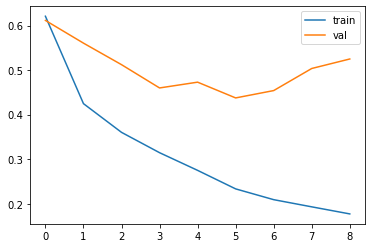

In [696]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [689]:
Y_pred = model.predict(X_test)

In [690]:
Y_pred

array([[9.78584111e-01, 2.14158446e-02],
       [9.79971707e-01, 2.00282969e-02],
       [9.81781960e-01, 1.82180554e-02],
       [9.83063281e-01, 1.69367082e-02],
       [9.82402265e-01, 1.75978038e-02],
       [9.81294870e-01, 1.87050831e-02],
       [9.78998125e-01, 2.10019369e-02],
       [9.76136744e-01, 2.38632187e-02],
       [9.75264072e-01, 2.47359686e-02],
       [9.75692034e-01, 2.43079048e-02],
       [9.76257622e-01, 2.37423200e-02],
       [9.77977872e-01, 2.20221467e-02],
       [9.81138110e-01, 1.88619420e-02],
       [9.83170569e-01, 1.68294664e-02],
       [9.84660208e-01, 1.53397443e-02],
       [9.85637009e-01, 1.43629145e-02],
       [9.86923754e-01, 1.30762113e-02],
       [9.87760901e-01, 1.22391135e-02],
       [9.87363636e-01, 1.26363551e-02],
       [9.86074507e-01, 1.39255133e-02],
       [9.86328065e-01, 1.36718797e-02],
       [9.85481858e-01, 1.45180896e-02],
       [9.87011313e-01, 1.29886763e-02],
       [9.88016725e-01, 1.19831963e-02],
       [9.884401

In [691]:
Y_pred_labels = np.argmax(Y_pred,axis=1)

In [692]:
Y_pred_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Accuracy:	87.50000%



The Classification Report is
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       246
           1       0.99      0.61      0.76       114

    accuracy                           0.88       360
   macro avg       0.92      0.80      0.84       360
weighted avg       0.89      0.88      0.87       360






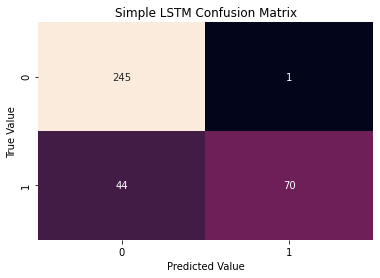

In [718]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print('Accuracy:\t{:0.5f}%'.format(accuracy_score(test_Y,Y_pred_labels)*100))
print("\n\n")
print("The Classification Report is")
print(classification_report(test_Y, Y_pred_labels))
print("\n\n")
# print("The Confusion Matrix is")
matrix = confusion_matrix(test_Y, Y_pred_labels)
plot1 = sns.heatmap(matrix,annot=True,cbar=False,fmt='d')  
plt.ylabel('True Value')  
plt.xlabel('Predicted Value')  
plt.title('Simple LSTM Confusion Matrix')  
plt.show()

In [711]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=True))

model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))

model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 20, 32)            128       
_________________________________________________________________
batch_normalization_8 (Batch (None, 20, 32)            128       
_________________________________________________________________
dropout_37 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 20, 32)            8320      
_________________________________________________________________
dropout_38 (Dropout)         (None, 20, 32)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_39 (Dropout)         (None, 32)              

In [712]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

history_2 = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.1, callbacks=[early_stop])



# model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2)

Epoch 1/100
30/30 - 1s - loss: 0.4758 - accuracy: 0.7683 - val_loss: 0.4737 - val_accuracy: 0.8571
Epoch 2/100
30/30 - 0s - loss: 0.3214 - accuracy: 0.8603 - val_loss: 0.4132 - val_accuracy: 0.8476
Epoch 3/100
30/30 - 0s - loss: 0.2789 - accuracy: 0.8751 - val_loss: 0.3378 - val_accuracy: 0.8381
Epoch 4/100
30/30 - 0s - loss: 0.2606 - accuracy: 0.8815 - val_loss: 0.3064 - val_accuracy: 0.8667
Epoch 5/100
30/30 - 0s - loss: 0.2096 - accuracy: 0.9101 - val_loss: 0.3108 - val_accuracy: 0.8476
Epoch 6/100
30/30 - 0s - loss: 0.1834 - accuracy: 0.9280 - val_loss: 0.3481 - val_accuracy: 0.8286
Epoch 7/100
30/30 - 0s - loss: 0.1659 - accuracy: 0.9302 - val_loss: 0.3852 - val_accuracy: 0.8381
Epoch 00007: early stopping


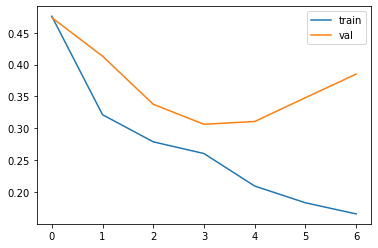

In [713]:
from matplotlib import pyplot

pyplot.plot(history_2.history['loss'], label='train')
pyplot.plot(history_2.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()

In [714]:
Y_pred_mod = model.predict(X_test)

In [715]:
Y_pred_labels_mod = np.argmax(Y_pred_mod,axis=1)

In [716]:
Y_pred_labels_mod

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

Accuracy:	90.00000%



The Classification Report is
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       246
           1       0.93      0.74      0.82       114

    accuracy                           0.90       360
   macro avg       0.91      0.86      0.88       360
weighted avg       0.90      0.90      0.90       360






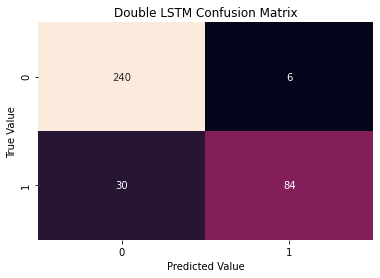

In [719]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print('Accuracy:\t{:0.5f}%'.format(accuracy_score(test_Y,Y_pred_labels_mod)*100))
print("\n\n")
print("The Classification Report is")
print(classification_report(test_Y, Y_pred_labels_mod))
print("\n\n")
# print("The Confusion Matrix is")
matrix = confusion_matrix(test_Y, Y_pred_labels_mod)
plot1 = sns.heatmap(matrix,annot=True,cbar=False,fmt='d')  
plt.ylabel('True Value')  
plt.xlabel('Predicted Value')  
plt.title('Double LSTM Confusion Matrix')  
plt.show()